# 问题汇总
- 交叉熵损失函数


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 防止内核崩溃
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# 检验GPU是否可用
print("GPU是否可用:", torch.cuda.is_available())
print("GPU数量:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("当前GPU:", torch.cuda.get_device_name(0))

GPU是否可用: True
GPU数量: 1
当前GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:


# 设置数据转换，将Tensor正规化到[-1,1]之间，并添加通道维度
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 下载训练集和测试集
train_dataset = datasets.MNIST('./data', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 验证数据集大小
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

训练集大小: 60000
测试集大小: 10000


图片形状: torch.Size([1, 28, 28])
标签: 5


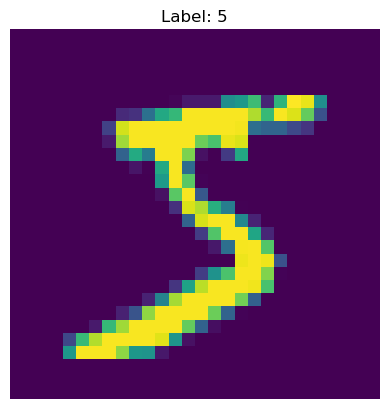

In [5]:
# 1. 查看单个样本
image, label = train_dataset[0]  # 获取第一个样本
print("图片形状:", image.shape)   # 应该是 [1, 28, 28]
print("标签:", label)            # 0-9之间的数字

# 去掉单通道维度，重塑图片形状为28x28
img_reshaped = image.squeeze().numpy()

# 显示图片
plt.figure()
plt.imshow(img_reshaped)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

# 关闭图形以释放内存
plt.close()

In [6]:
# help(train_dataset)
# dir(train_dataset)
X_train, y_train = train_dataset.data, train_dataset.targets  # 获取训练数据和标签
print(X_train.shape, y_train.shape)  # 打印训练数据和标签的形状
X_train = X_train.view(X_train.shape[0], -1)  # 将训练数据展平
print(X_train.shape)  # 打印展平后的训练数据形状

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([60000, 784])


In [7]:
# 自定义一个线性模型的例子

bs = 64 # batch size
xb = X_train[:bs]  # 获取前64个样本
yb = y_train[:bs]  # 获取前64个标签
weights = torch.randn(28*28, 10) / 28*28  # 初始化权重矩阵，调整为10个输出类别
bias = torch.zeros(1)  # 初始化偏置

def modle(xb, weights, bias):  # 定义模型函数，输入xb、weights和bias
    xb = xb.float()
    return xb.mm(weights) + bias  # 定义模型，线性层的前向传播

# 定义损失函数为交叉熵损失
loss_fn = F.cross_entropy  

xb = xb.float()  # 将xb转换为float类型
outputs = modle(xb, weights=weights, bias=bias)  # 计算输出
print(loss_fn(outputs, yb))  # 计算损失

tensor(4196.1792)


In [8]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__() # 调用父类的构造函数
        self.layer1 = nn.Linear(28*28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # 添加Dropout层，防止过拟合

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x

In [9]:
model = Mnist_NN()  # 实例化模型
print(model)  # 打印模型结构

Mnist_NN(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
for name, param in model.named_parameters():
    print(name,': ', param.shape)  # 打印模型参数的名称和形状

layer1.weight :  torch.Size([128, 784])
layer1.bias :  torch.Size([128])
layer2.weight :  torch.Size([64, 128])
layer2.bias :  torch.Size([64])
layer3.weight :  torch.Size([10, 64])
layer3.bias :  torch.Size([10])


In [11]:
criterion = nn.CrossEntropyLoss()  # 定义损失函数为交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 定义优化器为Adam，学习率为0.001

In [12]:
epochs = 5  # 训练轮数
for epoch in range(epochs):
    model.train()
    for data in train_loader:
        X_train, y_train = data
        X_train = X_train.view(X_train.size(0), -1)
        print(X_train.shape, y_train.shape)  # 打印训练数据和标签的形状
        
        outputs = model(X_train)  # 前向传播
        loss = loss_fn(outputs, y_train)  # 计算损失
        optimizer.zero_grad()  # 梯度清零

        
        break

torch.Size([64, 784]) torch.Size([64])
torch.Size([64, 784]) torch.Size([64])
torch.Size([64, 784]) torch.Size([64])
torch.Size([64, 784]) torch.Size([64])
torch.Size([64, 784]) torch.Size([64])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

epochs = 5  # 训练轮数
lr = 0.001  # 学习率
batch_size = 64  # 批大小
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        X_train, y_train = data
        X_train = X_train.view(X_train.size(0), -1).to(device)
        y_train = y_train.to(device)
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            X_test, y_test = data
            X_test = X_test.view(X_test.size(0), -1).to(device)
            y_test = y_test.to(device)
            
            outputs = model(X_test)
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 0.4490, Accuracy: 93.50%
Epoch [2/5], Loss: 0.2159, Accuracy: 95.26%
Epoch [3/5], Loss: 0.1618, Accuracy: 96.09%
Epoch [4/5], Loss: 0.1364, Accuracy: 96.44%
Epoch [5/5], Loss: 0.1180, Accuracy: 96.48%


In [14]:
# 检查模型是否在 GPU 上
print(next(model.parameters()).device)

# 检查数据是否在 GPU 上
print(X_train.device)

cuda:0
cuda:0


In [15]:
# Ensure the directory exists
os.makedirs('models', exist_ok=True)

# Save the model
torch.save(model, 'models/Mnist_NN.pth')

Predicted:  7


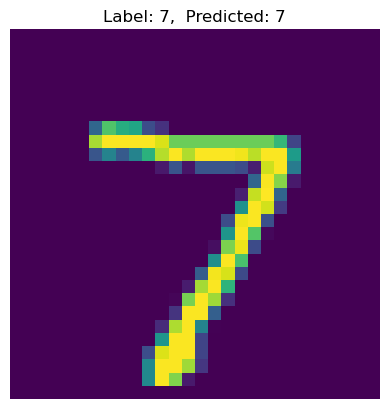

In [16]:
# Allowlist the custom class Mnist_NN
torch.serialization.add_safe_globals([Mnist_NN])

# Load the model
model = torch.load('models/Mnist_NN.pth', weights_only=False)

model.eval()  # 切换到评估模式
# 加载测试集数据
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)  # 这里设置 batch_size 为 1，因为我们只需要对一张图片进行预测

# 进行预测
with torch.no_grad():  # 禁用梯度计算，因为我们不需要反向传播
    for data in test_loader:  # 遍历测试集数据
        images, labels = data  # 获取图片和标签
        images = images.view(images.size(0), -1).to(device)  # 将图片展平并移动到与模型相同的设备
        labels = labels.to(device)
        
        outputs = model(images)  # 进行前向传播，得到模型的输出
        _, predicted = torch.max(outputs.data, 1)  # 找到输出中概率最大的类别
        print('Predicted: ', predicted.item())  # 打印预测结果
        
        # 显示图片
        img = images[0].cpu().numpy()  # 将图片从 GPU 移动到 CPU，并转换为 numpy 数组
        img = img.reshape(28, 28)  # 将图片从 (784,) 转换为 (28, 28) 的形状
        plt.imshow(img)  # 显示图片
        plt.title(f'Label: {labels[0]},  Predicted: {predicted.item()}')
        plt.axis('off')
        plt.show()  # 显示图片
        break  # 只显示一张图片，所以退出循环